In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

import sys
sys.path.append('../')

import dyflownet as dfn

In [2]:
sending1 = lambda rho: np.minimum(rho, 1)
sending2 = lambda rho: np.minimum(rho, 1) / 2

receiving1 = lambda rho: np.maximum(np.minimum(1, 0.25*(5-rho)), 0)
receiving2 = lambda rho: np.maximum(np.minimum(0.5, 0.25*(2.5-rho)), 0)

intercell_flow1 = lambda rho1, rho2: 1.2 * np.exp(-rho1) / (np.exp(-rho1) + np.exp(-rho2))
intercell_flow2 = lambda rho1, rho2: 1.2 * np.exp(-rho2) / (np.exp(-rho1) + np.exp(-rho2))

f1_unbounded_receiving = lambda rho1, rho2: intercell_flow1(rho1, rho2) - sending1(rho1)
f2_unbounded_receiving = lambda rho1, rho2: intercell_flow2(rho1, rho2) - sending2(rho2)

f1_bounded_receiving = lambda rho1, rho2: np.minimum(intercell_flow1(rho1, rho2), receiving1(rho1)) - sending1(rho1)
f2_bounded_receiving = lambda rho1, rho2: np.minimum(intercell_flow2(rho1, rho2), receiving2(rho2)) - sending2(rho2)


def eqs_unbounded_receiving(rho):
    rho1, rho2 = rho
    return [f1_unbounded_receiving(rho1, rho2), f2_unbounded_receiving(rho1, rho2)]


def eqs_bounded_receiving(rho):
    rho1, rho2 = rho
    return [f1_bounded_receiving(rho1, rho2), f2_bounded_receiving(rho1, rho2)]
    

## Unbounded Receiving Flow

In [3]:
num_x_grid, num_y_grid = 26, 31

initial_condition = dfn.utils.generate_boundary_combos(np.linspace(0, 5, num_x_grid), np.linspace(0, 6, num_y_grid))

state_len = len(initial_condition[0, :])

net_0 = dfn.net.Network(ID = 'net_0', state_len = state_len, num_step = 10000, time_step_size = 0.01)

source_0 = dfn.cell.Source(ID = 'source_0', initial_condition = {'density': [0]*state_len}, 
                           boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=1.2),
                           sending = dfn.flow.BufferSendingFlow(demand=1.2, capacity=2, ignore_queue=True))

sink_0 = dfn.cell.Sink(ID = 'sink_0', initial_condition = {'density': initial_condition[0, :]}, 
                       receiving = dfn.flow.UnboundedReceivingFlow(),
                       boundary_outflow = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1))

sink_1 = dfn.cell.Sink(ID = 'sink_1', initial_condition = {'density': initial_condition[1, :]}, 
                       receiving = dfn.flow.UnboundedReceivingFlow(),
                       boundary_outflow = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=0.5, capacity=0.5))

junction_0 = dfn.node.RoutedDivergeJunction(ID = 'node_0', incoming_cell_list = [source_0], outgoing_cell_list = [sink_0, sink_1],
                                            controller = dfn.controller.SoftmaxRoutingController(gain=[1, 1], cell_list=[sink_0, sink_1]))

# Add sources.
net_0.add_cell('source', source_0)

# Add sinks.
net_0.add_cell('sink', sink_0)
net_0.add_cell('sink', sink_1)

# Add nodes.
net_0.add_node(junction_0)


In [4]:
net_0.run()

source_0 initialized.
sink_0 initialized.
sink_1 initialized.
node_0 initialized.
time cost: 2.2 seconds.


In [5]:
X, Y = np.meshgrid(np.linspace(0, 5, num_x_grid), np.linspace(0, 6, num_y_grid))

X = X.flatten()
Y = Y.flatten()

vc_len = len(X)

sending_source_0 = source_0.flow_dict['sending'].compute_flow(vc_len)

receiving_sink_0 = sink_0.flow_dict['receiving'].compute_flow(vc_len)
outflow_sink_0 = sink_0.flow_dict['boundary_outflow'].compute_flow(X)

receiving_sink_1 = sink_1.flow_dict['receiving'].compute_flow(vc_len)
outflow_sink_1 = sink_1.flow_dict['boundary_outflow'].compute_flow(Y)

control_input = junction_0.controller.compute_control_input([X, Y])

inter_cell_flow_0 = junction_0.compute_inter_cell_flow(vc_len, [sending_source_0], [receiving_sink_0, receiving_sink_1], control_input)[:, 0, 0]
inter_cell_flow_1 = junction_0.compute_inter_cell_flow(vc_len, [sending_source_0], [receiving_sink_0, receiving_sink_1], control_input)[:, 0, 1]

U = inter_cell_flow_0 - outflow_sink_0
V = inter_cell_flow_1 - outflow_sink_1

norm = np.sqrt(U**2+V**2)

U_normed = np.divide(U, norm, out=np.zeros_like(U), where=norm!=0)
V_normed = np.divide(V, norm, out=np.zeros_like(V), where=norm!=0)

In [6]:
rho1_min = fsolve(lambda rho1: f1_unbounded_receiving(rho1, 0), 0.5)
rho1_max = fsolve(lambda rho1: f1_unbounded_receiving(rho1, 6), 0.5)

rho2_min = fsolve(lambda rho2: f2_unbounded_receiving(0, rho2), 0.5)
rho2_max = fsolve(lambda rho2: f2_unbounded_receiving(5, rho2), 0.5)

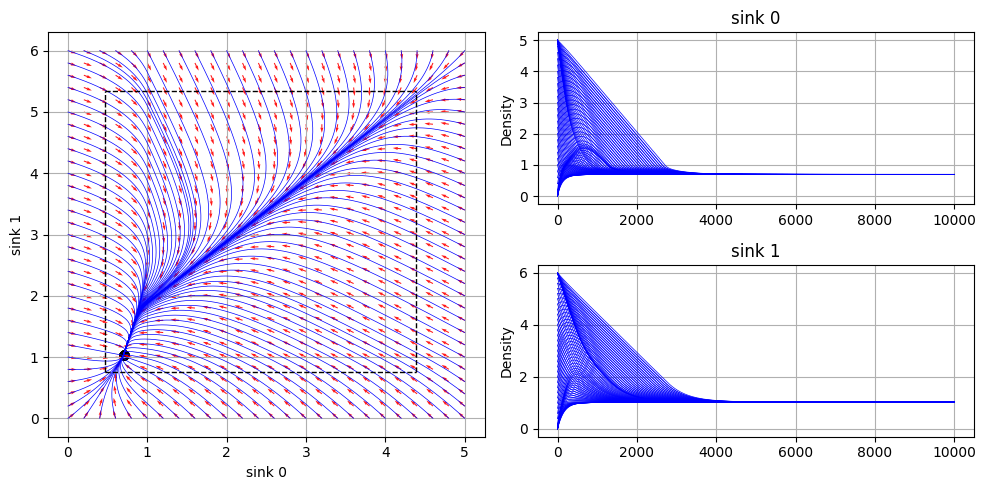

In [7]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.scatter(sink_0.state_output['density'][:, -1], sink_1.state_output['density'][:, -1],  color='k')
plt.plot(sink_0.state_output['density'].T, sink_1.state_output['density'].T,  'b', linewidth=0.5)

plt.quiver(X, Y, U_normed, V_normed, color='red', alpha=0.9, angles='xy')

plt.plot([rho1_min, rho1_min], [rho2_min, rho2_max], 'k--', linewidth=1)
plt.plot([rho1_max, rho1_max], [rho2_min, rho2_max], 'k--', linewidth=1)

plt.plot([rho1_min, rho1_max], [rho2_min, rho2_min], 'k--', linewidth=1)
plt.plot([rho1_min, rho1_max], [rho2_max, rho2_max], 'k--', linewidth=1)

plt.xlabel('sink 0')
plt.ylabel('sink 1')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(sink_0.state_output['density'].T, 'b', linewidth=0.5)
plt.title('sink 0')
plt.ylabel('Density')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(sink_1.state_output['density'].T, 'b', linewidth=0.5)
plt.title('sink 1')
plt.ylabel('Density')
plt.grid()

plt.tight_layout()

plt.savefig('vector_field_unbounded_receiving.pdf')

## Bounded Receiving Flow

In [8]:
num_x_grid, num_y_grid = 26, 26

initial_condition = dfn.utils.generate_boundary_combos(np.linspace(0, 5, num_x_grid), np.linspace(0, 2.5, num_y_grid))

state_len = len(initial_condition[0, :])

net_0 = dfn.net.Network(ID = 'net_0', state_len = state_len, num_step = 10000, time_step_size = 0.01)

source_0 = dfn.cell.Source(ID = 'source_0', initial_condition = {'density': [0]*state_len}, 
                           boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=1.2),
                           sending = dfn.flow.BufferSendingFlow(demand=1.2, capacity=2, ignore_queue=True))

sink_0 = dfn.cell.Sink(ID = 'sink_0', initial_condition = {'density': initial_condition[0, :]}, 
                       receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=5, capacity=1),
                       boundary_outflow = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1))

sink_1 = dfn.cell.Sink(ID = 'sink_1', initial_condition = {'density': initial_condition[1, :]}, 
                       receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=2.5, capacity=0.5),
                       boundary_outflow = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=0.5, capacity=0.5))

junction_0 = dfn.node.RoutedDivergeJunction(ID = 'node_0', incoming_cell_list = [source_0], outgoing_cell_list = [sink_0, sink_1],
                                            controller = dfn.controller.SoftmaxRoutingController(gain=[1, 1], cell_list=[sink_0, sink_1]))

# Add sources.
net_0.add_cell('source', source_0)

# Add sinks.
net_0.add_cell('sink', sink_0)
net_0.add_cell('sink', sink_1)

# Add nodes.
net_0.add_node(junction_0)

In [9]:
net_0.run()

source_0 initialized.
sink_0 initialized.
sink_1 initialized.
node_0 initialized.
time cost: 2.3 seconds.


In [10]:
rho1_min = fsolve(lambda rho1: f1_bounded_receiving(rho1, 0), 0.5)
rho1_max = fsolve(lambda rho1: f1_bounded_receiving(rho1, 2.5), 0.5)

rho2_min = fsolve(lambda rho2: f2_bounded_receiving(0, rho2), 0.5)
rho2_max = fsolve(lambda rho2: f2_bounded_receiving(5, rho2), 0.5)

In [11]:
X, Y = np.meshgrid(np.linspace(0, 5, num_x_grid), np.linspace(0, 2.5, num_y_grid))

X = X.flatten()
Y = Y.flatten()

vc_len = len(X)

sending_source_0 = source_0.flow_dict['sending'].compute_flow(vc_len)

receiving_sink_0 = sink_0.flow_dict['receiving'].compute_flow(X)
outflow_sink_0 = sink_0.flow_dict['boundary_outflow'].compute_flow(X)

receiving_sink_1 = sink_1.flow_dict['receiving'].compute_flow(Y)
outflow_sink_1 = sink_1.flow_dict['boundary_outflow'].compute_flow(Y)

control_input = junction_0.controller.compute_control_input([X, Y])

inter_cell_flow_0 = junction_0.compute_inter_cell_flow(vc_len, [sending_source_0], [receiving_sink_0, receiving_sink_1], control_input)[:, 0, 0]
inter_cell_flow_1 = junction_0.compute_inter_cell_flow(vc_len, [sending_source_0], [receiving_sink_0, receiving_sink_1], control_input)[:, 0, 1]

U = inter_cell_flow_0 - outflow_sink_0
V = inter_cell_flow_1 - outflow_sink_1

norm = np.sqrt(U**2+V**2)

U_normed = np.divide(U, norm, out=np.zeros_like(U), where=norm!=0)
V_normed = np.divide(V, norm, out=np.zeros_like(V), where=norm!=0)

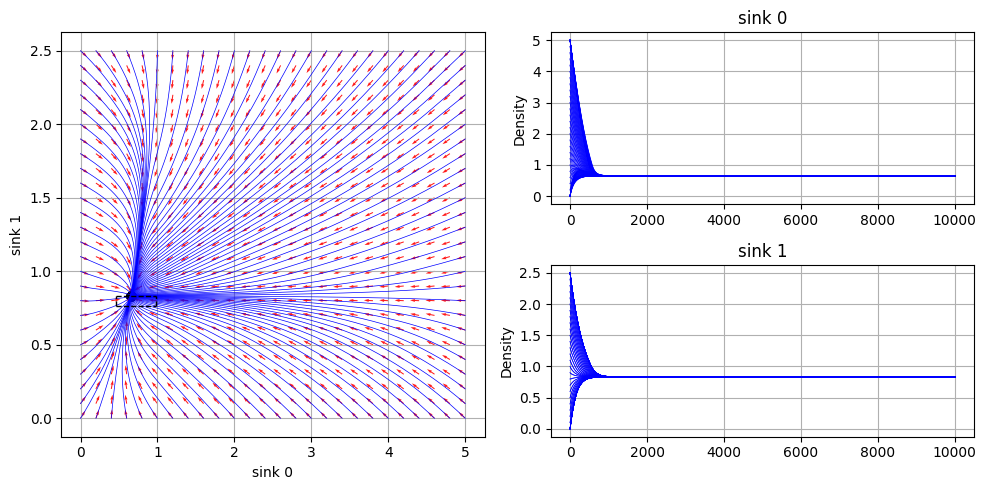

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.scatter(sink_0.state_output['density'][:, -1], sink_1.state_output['density'][:, -1],  color='k')

plt.plot(sink_0.state_output['density'].T, sink_1.state_output['density'].T,  'b', linewidth=0.5)

plt.quiver(X, Y, U_normed, V_normed, color='red', alpha=0.9, angles='xy')

plt.plot([rho1_min, rho1_min], [rho2_min, rho2_max], 'k--', linewidth=1, label='invariant set')
plt.plot([rho1_max, rho1_max], [rho2_min, rho2_max], 'k--', linewidth=1)

plt.plot([rho1_min, rho1_max], [rho2_min, rho2_min], 'k--', linewidth=1)
plt.plot([rho1_min, rho1_max], [rho2_max, rho2_max], 'k--', linewidth=1)

plt.xlabel('sink 0')
plt.ylabel('sink 1')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(sink_0.state_output['density'].T, 'b', linewidth=0.5)
plt.title('sink 0')
plt.ylabel('Density')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(sink_1.state_output['density'].T, 'b', linewidth=0.5)
plt.title('sink 1')
plt.ylabel('Density')
plt.grid()

plt.tight_layout()

plt.savefig('vector_field_bounded_receiving.pdf')